# Analysis of ETF performance by sector

## Questions to answer
1. Which ETF has the highest expense ratio
2. Which ETF has the highest dividend yield

3. What is the average performance of segment benchmark for 11 sectors using (across the analyzed time period)
4. What is the return of the S&P 500
5. Sharpe ratio of an etf vs other etf in same sector (see link)
    https://markets.ft.com/data/etfs/tearsheet/risk?s=XLF:PCQ:USD

In [6]:
import pandas as pd
import numpy as np
from selenium.webdriver.chrome.webdriver import WebDriver
from bs4 import BeautifulSoup
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('whitegrid')
sns.set_style(style='darkgrid')
from yahoo_historical import Fetcher
import plotly_express as px

### Reading files and loading to a Dataframe

In [ ]:
sectors_file = os.listdir('Data/ETF_sectors/')
print(sectors_file)

In [3]:
etf_df = pd.DataFrame()

for f in sectors_file:
    file = 'Data/ETF_sectors/'+f
    df = pd.read_csv(file)
    df['sector'] = re.findall('\w*', f)[0]
    etf_df = etf_df.append(df, ignore_index=True)

etf_df = etf_df[etf_df['Name'].notna()].reset_index(drop=True)
etf_df['Mgmnt Fee'] = etf_df['Mgmnt Fee'].str[:4].astype(float)
etf_df['Div Yield'] = etf_df['Div Yield'].str[:4].astype(float)
etf_df['Symbol'] = etf_df['Symbol'].str.rstrip()
etf_df['AUM'] = etf_df['AUM'].astype(str).str.replace(',', '').astype('float64')


shorts = etf_df[~etf_df['Leverage'].str.contains('Long')]
etf_df = etf_df[etf_df['Leverage'].str.contains('Long')]

etf_df = etf_df[etf_df['Leverage'].str.contains('^Long')]



etf_df.head()

Symbol                                          Name           AUM  \
0    ITB             US Home Construction Ishares ETF   1.274312e+09   
1   FDIS              Fidelity Consumer Disc MSCI ETF   7.251375e+08   
2    XHB                        S&P Homebuilders SPDR   6.865365e+08   
3    XRT                              S&P Retail SPDR   3.888087e+08   
4    PKB  Dynamic Building & Construction Invesco ETF   1.149750e+08   

  Asset Class Leverage  Mgmnt Fee Dividend(a)  Div Yield  \
0     Equity     Long        0.43        0.21       0.54   
1     Equity     Long        0.08        0.54       1.14   
2     Equity     Long        0.35        0.42       0.98   
3     Equity     Long        0.35        0.66       1.52   
4     Equity     Long        0.58        0.13       0.41   

                   sector  
0  Consumer_Discretionary  
1  Consumer_Discretionary  
2  Consumer_Discretionary  
3  Consumer_Discretionary  
4  Consumer_Discretionary

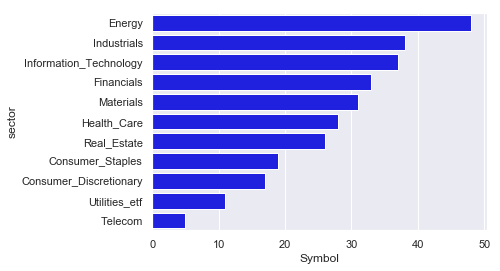

In [8]:
data = etf_df.groupby('sector').agg({'Symbol': 'count'}).reset_index()
data = data.sort_values('Symbol', ascending=False)
sns.barplot('Symbol', 'sector', data=data, color='blue')
#plt.xticks(list(range(data['sector'].shape[0])), data['sector'], rotation='vertical')
#px.bar(data, x='Symbol', y='sector', orientation='h')

In [22]:

#fig, ax = plt.subplots(figsize=(11,3))
#ax.set_xlim()


# ETF with the highest Fee
exp_etf = etf_df.loc[etf_df['Mgmnt Fee'].idxmax()]#['Symbol']
amuu = int(exp_etf['AUM'])
print('Ticker: {}, AUM: {}, Management Fee: {}, Dividend Yield: {},'.format(exp_etf['Symbol'], f'{amuu:,}', exp_etf['Mgmnt Fee'], exp_etf['Div Yield']))
#exp_etf

Ticker: BIZD, AUM: 213,590,000, Management Fee: 9.41, Dividend Yield: 9.69,


### Min and max AUM

In [142]:
etf_df.head()

#etf_df['AUM'].plot(kind='hist')
#myax = plt.hist(etf_df['AUM'], bins=20)
etf_df.describe()
#etf_df.info()
print(etf_df.loc[etf_df['AUM'].idxmin()])
etf_df.loc[etf_df['AUM'].idxmax()]

Symbol                         CHIE
Name           G-X China Energy ETF
AUM                       1.656e+06
Asset Class                  Equity
Leverage                       Long
Mgmnt Fee                      0.66
Dividend(a)                   0.569
Div Yield                       5.2
sector                       Energy
Name: 60, dtype: object


Symbol                               VNQ
Name           Real Estate Vanguard ETF 
AUM                          3.48075e+10
Asset Class                      Equity 
Leverage                           Long 
Mgmnt Fee                           0.12
Dividend(a)                         3.54
Div Yield                           3.95
sector                       Real_Estate
Name: 301, dtype: object

In [ ]:
def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')
    
#etf_df['AUM'].plot(kind='hist', bins=20)
plot_loghist(etf_df['AUM'], 20)
etf_df.describe()
#etf_df[etf_df['AUM']<=10**8]

fig, ax = plt.subplots(figsize=(11,11))
ax.set_xlim(0,1.5)
ax.set_ylim(0,15)
sns.scatterplot(x='Mgmnt Fee', y='Div Yield', hue='sector', data=etf_df)

In [7]:
def data_fetcher(etflist, start, end):
    """
    Takes in a list of etf symbols 
    returns pandas dataframe of price details and dividends
    """
    price_df = pd.DataFrame()
    dividend = pd.DataFrame()
    for e in etflist:
        data = Fetcher(e, start, end)
        pricedata = data.getHistorical()
        #print(e)
        if 'Date' in data.getHistorical().columns.tolist():
            pricedata['ticker'] = e
            price_df = price_df.append(pricedata)

            divddata = data.getDividends()
            divddata['ticker'] = e
            dividend = dividend.append(divddata)
    return price_df, dividend

In [71]:
elist = etf_df[etf_df['sector']=='Health_Care']['Symbol'].values

prices, dividends = data_fetcher(elist, [2012,1,1], [2018,12,31])

XLV
VHT
IBB
XBI
IHI
FBT
IXJ
IYH
FHLC
FXH
IHF
RYH
XHE
PSCH
PJP
BBH
IHE
PBE
XPH
PPH
PTH
XHS
JHMH
CNCR
BFIT
LNGR
HCRF
DXJH


In [72]:
price_group = prices.set_index('Date')
price_group['Daily_Returns'] = price_group.groupby('ticker')['Adj Close'].pct_change(1)
#fig,ax = plt.subplots(figsize=(20,11))
#sns.boxplot(x='ticker', y='Daily_Returns', data=price_group, ax=ax)


In [73]:
px.box(price_group[~price_group['ticker'].isin(['PXR', 'INDF'])], x='ticker', y='Daily_Returns')


In [74]:

pricedf = price_group.reset_index()
pricedf.head()
pricedf.iloc[pricedf['Date'].astype('datetime64[ns]').idxmin()]
idx = pricedf.groupby(['ticker'])['Date'].transform(min) == pricedf['Date']
#price_group[.index.idxmax]
pricedf['base'] = pricedf[idx]['Adj Close']
#pricedf.iloc[365*3-91]
pricedf['base'] = pricedf['base'].fillna(method='ffill')
pricedf['return'] = pricedf['Adj Close']/pricedf['base']
pricedf.head()

Date       Open       High        Low      Close  Adj Close  \
0  2012-01-03  35.099998  35.259998  35.029999  35.139999  31.134466   
1  2012-01-04  35.110001  35.130001  34.849998  34.970001  30.983856   
2  2012-01-05  34.779999  35.110001  34.709999  35.070000  31.072454   
3  2012-01-06  35.119999  35.209999  34.959999  35.130001  31.125626   
4  2012-01-09  35.200001  35.220001  34.910000  35.189999  31.178761   

       Volume ticker  Daily_Returns       base    return  
0  18864300.0    XLV            NaN  31.134466  1.000000  
1   6174000.0    XLV      -0.004837  31.134466  0.995163  
2   5939700.0    XLV       0.002859  31.134466  0.998008  
3   6762500.0    XLV       0.001711  31.134466  0.999716  
4  10695300.0    XLV       0.001707  31.134466  1.001423

In [75]:
idx = pricedf.groupby(['ticker'])['Date'].transform(max) == pricedf['Date']
inde = pricedf[idx]['return'].idxmax()
pricedf.iloc[inde]
returndf = pricedf[idx]
returndf = pd.merge(returndf, etf_df, how='left', left_on='ticker', right_on='Symbol')
px.scatter(returndf[~returndf['ticker'].isin(['PXR', 'INDF'])], y='return', x='Mgmnt Fee', color='ticker')

In [76]:
#price_group.groupby('ticker')['Adj Close'].pct_change(1)
#px.line(pricedf[pricedf['ticker'].isin(['BDC', 'INDF'])], x='Date', y='return', color='ticker')
px.line(pricedf[~pricedf['ticker'].isin(['BIZD'])], 'Date', y='return', line_group='ticker')
#sns.lineplot('Date', y='return', data=pricedf[~pricedf['ticker'].isin(['BIZD'])], hue='ticker')

In [78]:
drt = Fetcher('HYG', [2012,7,27])

In [79]:
mydf = drt.getHistorical()
print(mydf['Adj Close'].iloc[-1])
#(mydf['Close'][1902]-mydf['Close'][0])/mydf['Close'][0]
#drt.getDividends()
EB = mydf['Adj Close'].iloc[-1]
BB = (mydf['Adj Close'][0])
((EB/BB)**(1/(10))) - 1
EB/BB - 1

87.16999799999999


0.38937007072064356

In [56]:
etf_df[etf_df['Symbol']=='XAR']
etf_df.groupby([ 'sector', 'Leverage']).agg({'Symbol': 'count'})
#sns.barplot()
#etf_df['Div Yield']#[-1]
etf_df[etf_df['sector']=='Financials']#.Symbol.values
try:
    myd = Fetcher('TEFT', [2019,4,1]).getHistorical()
except KeyError:
    pass
    
#Fetcher(r'TEFT', [2018,1,1], [2018,4,1])
#pricedf.tail()
import quandl

In [57]:
data = quandl.get_table("ETFG/CONST", paginate=True)

LimitExceededError: (Status 429) (Quandl Error QELx01) You have exceeded the anonymous user limit of 50 calls per day. To make more calls today, please register for a free Quandl account and then include your API key with your requests.

In [107]:
mydf.set_index('Date')/mydf.set_index('Date').iloc[0]
pricedf
SP5 = Fetcher('VTI', [2006,1,1], [2019,6,30])


In [108]:
sp500 = SP5.getHistorical()
sp500['return'] = sp500['Adj Close'].pct_change()
sp500.head()

Date       Open       High        Low      Close  Adj Close   Volume  \
0  2006-01-03  61.855000  62.730000  61.430000  62.575001  48.054817  1769800   
1  2006-01-04  62.660000  63.029999  62.625000  63.029999  48.404240   763600   
2  2006-01-05  62.985001  63.055000  62.779999  62.990002  48.373539   258200   
3  2006-01-06  63.415001  63.634998  63.115002  63.610001  48.849655   436000   
4  2006-01-09  63.665001  63.939999  63.610001  63.845001  49.030117   689600   

     return  
0       NaN  
1  0.007271  
2 -0.000634  
3  0.009842  
4  0.003694

C:\Users\emax4\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\emax4\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning:

invalid value encountered in less_equal



Open         -0.825875
High         -0.824995
Low          -0.826602
Close        -0.826931
Adj Close    -0.804938
Volume       56.108264
return       11.456126
dtype: float64

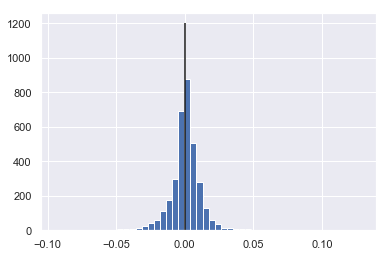

In [110]:
#sp500['return'].plot(kind='hist', bins=40)
ax = plt.hist(sp500['return'], bins=50)
plt.vlines(sp500['return'].mean(), 0, 1200)
#plt.axvline(0.03)
sp500.kurtosis()